# Imports

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Load the data

In [6]:

# 1. Load and prepare the data
# Using a publicly available sunspots dataset
url = 'https://storage.googleapis.com/edulabs-public-datasets/sunspots.csv'
df = pd.read_csv(url, index_col='Month', parse_dates=True)



In [9]:
df

,Sunspots
Month,
1749-01-01,58.0
1749-02-01,62.6
1749-03-01,70.0
1749-04-01,55.7
1749-05-01,85.0
...,...
1983-08-01,71.8
1983-09-01,50.3
1983-10-01,55.8


In [10]:
sunspots_series = df['Sunspots'].to_numpy()

In [11]:
sunspots_series.shape

(2820,)

# Split dataset

In [139]:
def create_dataset(series, window_size, batch_size, shuffle_buffer, training=True):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))

    if training:
        ds = ds.shuffle(shuffle_buffer)

    ds = ds.map(lambda window: (window[:-1], tf.cast(window[-1], tf.float32))) # Cast target to float32
    ds = ds.batch(batch_size)

    if training:
        ds = ds.repeat()

    ds = ds.prefetch(1)
    return ds

In [140]:

window_size = 12
batch_size = 36
shuffle_buffer = 1000

split = int(len(sunspots_series) * 0.8)
train_series = sunspots_series[:split]
val_series = sunspots_series[split:]

min_val = train_series.min()
max_val = train_series.max()

train_series_normalized = (train_series - min_val) / (max_val - min_val)
val_series_normalized = (val_series - min_val) / (max_val - min_val)

train_dataset = create_dataset(train_series_normalized, window_size, batch_size, shuffle_buffer, training=True)
validation_dataset = create_dataset(val_series_normalized, window_size, batch_size, shuffle_buffer=1, training=False)

steps_per_epoch = (len(train_series) - window_size) // batch_size
validation_steps = max(1, (len(val_series) - window_size) // batch_size)

In [141]:
train_series.shape

(2256,)

# Build CNN model

In [142]:

# 2. Build the CNN Model
# We reshape the input for the 1D Convolutional layer
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=[window_size]),
    tf.keras.layers.Reshape((window_size, 1)),
    tf.keras.layers.Conv1D(32, kernel_size=5, activation='relu'),
    tf.keras.layers.Conv1D(16, kernel_size=3, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_22 (Reshape)            │ (None, 12, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_46 (Conv1D)              │ (None, 8, 32)          │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_47 (Conv1D)              │ (None, 6, 16)          │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_21     │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,761 (6.88 KB)

 Trainable params: 1,761 (6.88 KB)

 Non-trainable params: 0 (0.00 B)

In [143]:

# 3. Compile and Train the Model
model.compile(loss='mse', optimizer='adam', metrics=['mae'])


In [148]:
history = model.fit(
    train_dataset,
    batch_size=batch_size,
    epochs=15,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_dataset,
    validation_steps=validation_steps,
    verbose=1
)

Epoch 1/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - mae: 0.0478 - val_loss: 0.0082 - val_mae: 0.0672
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0049 - mae: 0.0490 - val_loss: 0.0076 - val_mae: 0.0661
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0045 - mae: 0.0475 - val_loss: 0.0092 - val_mae: 0.0705
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0045 - mae: 0.0474 - val_loss: 0.0078 - val_mae: 0.0657
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0042 - mae: 0.0472 - val_loss: 0.0085 - val_mae: 0.0682
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0045 - mae: 0.0466 - val_loss: 0.0077 - val_mae: 0.0651
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0048 - mae: 0.0471 - val_loss: 0.0073 - val_mae: 0.0644
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0046 - mae: 0.0480 - val_loss: 0.0073 - val_mae: 0.0647
Epoch 9/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0045 

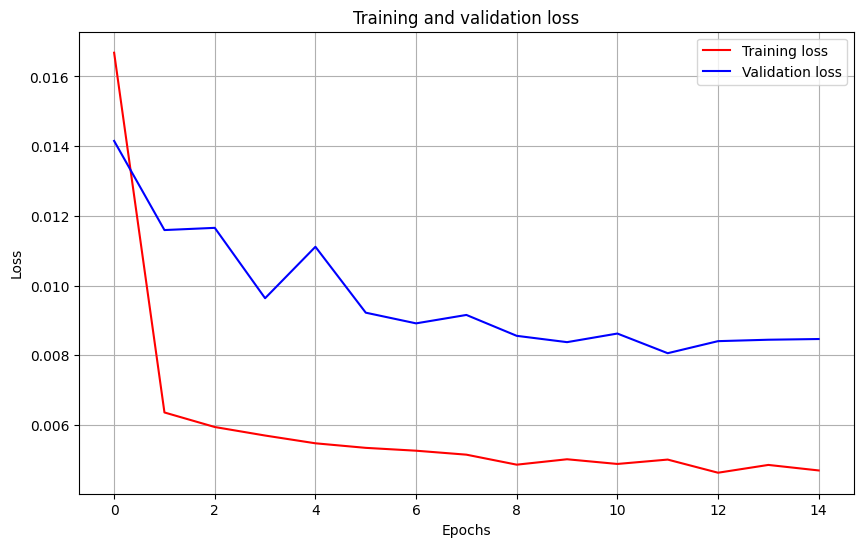

In [145]:
import matplotlib.pyplot as plt
# Plot the training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

552/552 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


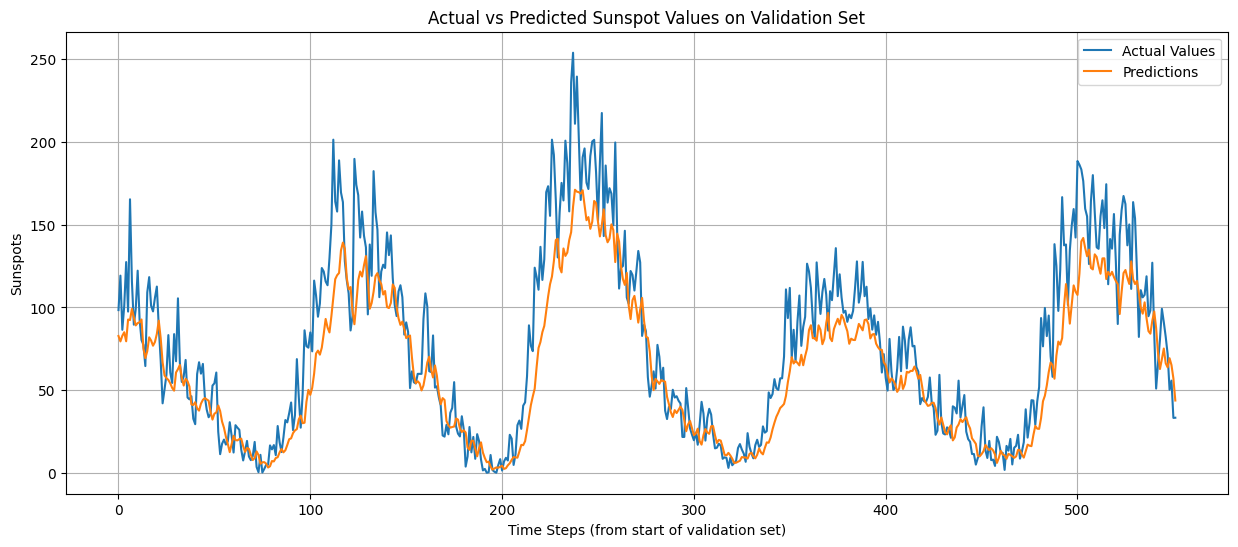

In [155]:
# prompt: plot predictions on val

import matplotlib.pyplot as plt
# Generate predictions for the validation set
# We need to recreate the validation dataset without batching for prediction
val_dataset_flat = tf.data.Dataset.from_tensor_slices(val_series)
val_dataset_flat = val_dataset_flat.window(window_size + 1, shift=1, drop_remainder=True)
val_dataset_flat = val_dataset_flat.flat_map(lambda window: window.batch(window_size + 1))
val_dataset_flat = val_dataset_flat.map(lambda window: window[:-1]) # Get only the features
val_dataset_flat = val_dataset_flat.batch(1) # Add batch dimension


predictions = model.predict(val_dataset_flat)

# Prepare actual values from the validation set
actual_values = val_series[window_size:]

# Plot actual vs predicted values
plt.figure(figsize=(15, 6))
plt.plot(actual_values, label='Actual Values')
plt.plot(predictions, label='Predictions')
plt.title('Actual vs Predicted Sunspot Values on Validation Set')
plt.xlabel('Time Steps (from start of validation set)')
plt.ylabel('Sunspots')
plt.legend()
plt.grid(True)
plt.show()